# Fine-Tuning BERTweet on the Hate Speech Detection Task

## Loading Libraries and Dataset

Installing and importing the required libraries.

In [1]:
!pip install simpletransformers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm.notebook import tqdm
tqdm.pandas()

import csv
import torch
import logging
import itertools

# Import the ClassificationModel module as we need to do multi-class text classification
from simpletransformers.classification import ClassificationModel

import sklearn
from sklearn.metrics import f1_score, accuracy_score

In [3]:
!pip install emoji
from nltk.tokenize import TweetTokenizer
from emoji import demojize
import re

Loading the dataset

In [4]:
hate_train_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt", sep="\n", skip_blank_lines=False, header=None, quoting=csv.QUOTE_NONE,)
hate_train_df.columns= ["tweet"]
hate_train_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt", sep="\n", header=None)
hate_train_labels.columns= ["label"]

hate_val_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_text.txt", sep="\n", skip_blank_lines=False, quoting=csv.QUOTE_NONE, header=None)
hate_val_df.columns= ["tweet"]
hate_val_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/val_labels.txt", sep="\n", header=None)
hate_val_labels.columns= ["label"]

hate_test_df = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt", sep="\n", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_test_df.columns= ["tweet"]
hate_test_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt", sep="\n", header=None)
hate_test_labels.columns= ["label"]

hate_train_df

,tweet
0,@user nice new signage. Are you not concerned ...
1,A woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user
...,...
8995,Oooohhhh bitch didn't even listen to the dead ...
8996,@user Good Luck @user More Americans #WalkAway...
8997,Bitch you can't keep up so stop trying
8998,@user @user @user @user @user @user Japan is a...


Making sure that the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets to match the dimensions of their corresponding labels dataframes.

In [5]:
# Checking whether the data is loaded correctly by checking the dimensions of the data frames for the training, validation, and testing datasets matches the dimensions of their corresponding labels datasets.
print(hate_train_df.shape, hate_train_labels.shape)
print(hate_val_df.shape, hate_val_labels.shape)
print(hate_test_df.shape, hate_test_labels.shape)

(9000, 1) (9000, 1)
(1000, 1) (1000, 1)
(2970, 1) (2970, 1)


## Exploratory Data Analysis

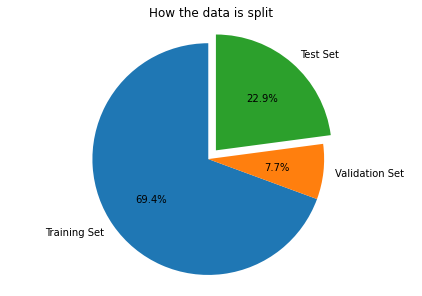

In [6]:
# Pie chart showing how data is split
labels = ['Training Set', 'Validation Set', 'Test Set']
sizes = [len(hate_train_labels), len(hate_val_labels), len(hate_test_labels)]
explode = (0, 0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("How the data is split")
plt.show()

In [7]:
# Checking the labels
hate_labels = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/mapping.txt", sep="\t", header=None)
hate_labels

,0,1
0,0,not-hate
1,1,hate


Data statitics:

In [8]:
print("Training Data Statistics: ")
print("Total number of tweets:", hate_train_labels.shape[0])
print("Number of Not Hateful tweets:", int(hate_train_labels.value_counts()[0]))
print("Number of Hateful tweets:", int(hate_train_labels.value_counts()[1]), "\n")

print("Validation Data Statistics: ")
print("Total number of tweets:", hate_val_labels.shape[0])
print("Number of Not Hateful tweets:", int(hate_val_labels.value_counts()[0]))
print("Number of Hateful tweets:", int(hate_val_labels.value_counts()[1]), "\n")

print("Testing Data Statistics: ")
print("Total number of tweets:", hate_test_labels.shape[0])
print("Number of Not Hateful tweets:", int(hate_test_labels.value_counts()[0]))
print("Number of Hateful tweets:", int(hate_test_labels.value_counts()[1]))

Training Data Statistics: 
Total number of tweets: 9000
Number of Not Hateful tweets: 5217
Number of Hateful tweets: 3783 

Validation Data Statistics: 
Total number of tweets: 1000
Number of Not Hateful tweets: 573
Number of Hateful tweets: 427 

Testing Data Statistics: 
Total number of tweets: 2970
Number of Not Hateful tweets: 1718
Number of Hateful tweets: 1252


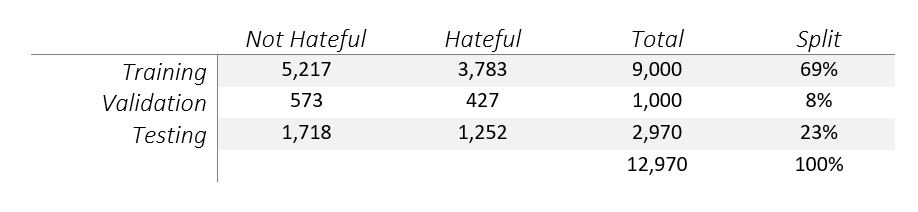

In [9]:
data = hate_train_labels.groupby("label").sum()
data

""
label
0
1


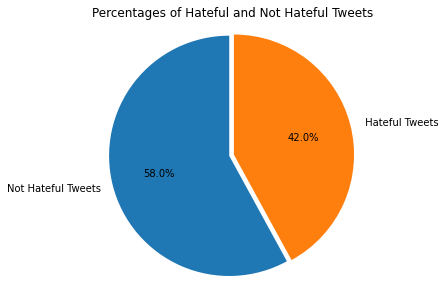

In [10]:
# Pie chart shwoing percentages of classes
not_hateful_count = hate_train_labels[hate_train_labels.label == 0].shape[0]
hateful_count = hate_train_labels[hate_train_labels.label == 1].shape[0]

labels = ['Not Hateful Tweets', ' Hateful Tweets']
sizes = [not_hateful_count, hateful_count]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentages of Hateful and Not Hateful Tweets")
plt.show()

[Text(0, 0, 'Not Hateful Tweets'), Text(0, 0, ' Hateful Tweets')]

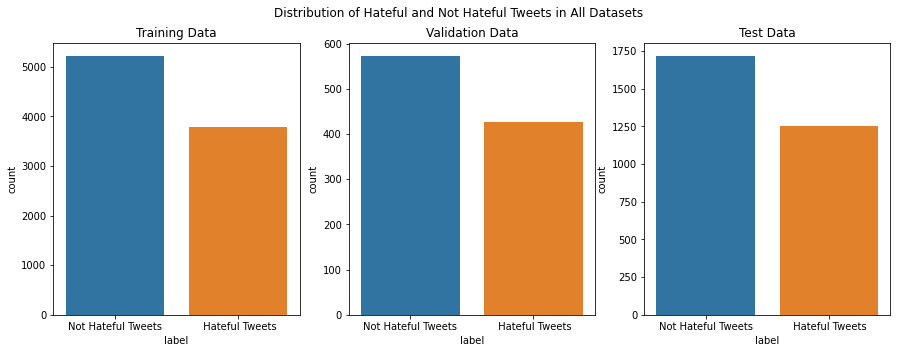

In [11]:
# Count Plots shwoing Distribution of Hateful and Not Hateful Tweets in All Datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of Hateful and Not Hateful Tweets in All Datasets')

sns.countplot(ax=axes[0], x=hate_train_labels.label)
axes[0].set_title('Training Data')
axes[0].set_xticklabels(labels)

sns.countplot(ax=axes[1], x=hate_val_labels.label)
axes[1].set_title('Validation Data')
axes[1].set_xticklabels(labels)

sns.countplot(ax=axes[2], x=hate_test_labels.label)
axes[2].set_title('Test Data')
axes[2].set_xticklabels(labels)

## Exploring the tokenization and attention mask process

In [12]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Emojis are not recognized by the tokenizer so they are tokenized as [UNK].


In [13]:
hate_train_df.iloc[30,0]

"@user @user Omg he gave her his number and she didn't say no what a cunt The girl is the cunt for giving it to some random fucktard "

In [14]:
# tokenizing and removing white spaces while keepng punctuation
tweet_sample = hate_train_df.iloc[30,0]
token_sample = tokenizer.tokenize(tweet_sample)
print(token_sample)

['@', 'user', '@', 'user', 'om', '##g', 'he', 'gave', 'her', 'his', 'number', 'and', 'she', 'didn', "'", 't', 'say', 'no', 'what', 'a', 'cu', '##nt', 'the', 'girl', 'is', 'the', 'cu', '##nt', 'for', 'giving', 'it', 'to', 'some', 'random', 'fuck', '##tar', '##d']


Converting the corpus into tokens and then converting each token to its ID, which is a unique integer representing the index of that token in the vocabulary of the model.


In [15]:
token_id_sample = tokenizer.convert_tokens_to_ids(token_sample)
print(token_id_sample)

[1030, 5310, 1030, 5310, 18168, 2290, 2002, 2435, 2014, 2010, 2193, 1998, 2016, 2134, 1005, 1056, 2360, 2053, 2054, 1037, 12731, 3372, 1996, 2611, 2003, 1996, 12731, 3372, 2005, 3228, 2009, 2000, 2070, 6721, 6616, 7559, 2094]


We have to provide sequences of equal length therefore we'll add some padding, then pass "attention mask" where each term has a value of 1 and each padding token has a value of 0.

Special tokens are needed for separating betwen sentences, that's how BERT initially trained on squence classification.

Exploring types of tokens when encoding them into IDs:


In [16]:
print("Types of tokens and their IDs:", tokenizer.special_tokens_map)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id) # CLS is sequence/text classification task
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.mask_token, tokenizer.mask_token_id)

Types of tokens and their IDs: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
[PAD] 0
[UNK] 100
[CLS] 101
[SEP] 102
[MASK] 103


Exploring the encoding process

In [17]:
encoding = tokenizer.encode_plus( # why plus?
        
    text = tweet_sample,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    # pad_to_max_length=True,
    truncation=True,
    max_length=60, # number of tokens
    padding='max_length',
    return_attention_mask = True,
    return_tensors='pt',  # Return PyTorch tensors, and tf can be used for TensorFlow as well
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The Attention Mask giving the values of 1 to all tokens, except the padding tokens in which it gives them the value of 0.

In [18]:
encoded_seq = encoding['input_ids'][0]
print("Encoded sequence (IDs):\n", encoded_seq)
print("Attention Mask:\n", encoding['attention_mask'])

Encoded sequence (IDs):
 tensor([  101,  1030,  5310,  1030,  5310, 18168,  2290,  2002,  2435,  2014,
         2010,  2193,  1998,  2016,  2134,  1005,  1056,  2360,  2053,  2054,
         1037, 12731,  3372,  1996,  2611,  2003,  1996, 12731,  3372,  2005,
         3228,  2009,  2000,  2070,  6721,  6616,  7559,  2094,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


## Pre-Processing Steps

In [19]:
# Checking for null values
print("Number of NULL values in the hate training set: ", hate_train_df['tweet'].isnull().values.sum())
print("Number of NULL values in the hate validation set: ", hate_val_df['tweet'].isnull().values.sum())
print("Number of NULL values in the hate testing set: ", hate_test_df['tweet'].isnull().values.sum(), '\n')

Number of NULL values in the hate training set:  7
Number of NULL values in the hate validation set:  1
Number of NULL values in the hate testing set:  0 



In [20]:
print(hate_train_df.shape)
print(hate_train_labels.shape)
hate_train_df

(9000, 1)
(9000, 1)


,tweet
0,@user nice new signage. Are you not concerned ...
1,A woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user
...,...
8995,Oooohhhh bitch didn't even listen to the dead ...
8996,@user Good Luck @user More Americans #WalkAway...
8997,Bitch you can't keep up so stop trying
8998,@user @user @user @user @user @user Japan is a...


In [21]:
hate_train_labels

,label
0,0
1,1
2,1
3,1
4,0
...,...
8995,0
8996,0
8997,1
8998,0


In [22]:
df = pd.concat([hate_train_df, hate_train_labels], axis=1)
df

,tweet,label
0,@user nice new signage. Are you not concerned ...,0
1,A woman who you fucked multiple times saying y...,1
2,@user @user real talk do you have eyes or were...,1
3,your girlfriend lookin at me like a groupie in...,1
4,Hysterical woman like @user,0
...,...,...
8995,Oooohhhh bitch didn't even listen to the dead ...,0
8996,@user Good Luck @user More Americans #WalkAway...,0
8997,Bitch you can't keep up so stop trying,1
8998,@user @user @user @user @user @user Japan is a...,0


In [23]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [24]:
hate_train_df = df[['tweet']]
hate_train_labels = df[['label']]
hate_train_df

,tweet
0,@user nice new signage. Are you not concerned ...
1,A woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user
...,...
8988,Oooohhhh bitch didn't even listen to the dead ...
8989,@user Good Luck @user More Americans #WalkAway...
8990,Bitch you can't keep up so stop trying
8991,@user @user @user @user @user @user Japan is a...


In [25]:
hate_train_labels

,label
0,0
1,1
2,1
3,1
4,0
...,...
8988,0
8989,0
8990,1
8991,0


In [26]:
print("Number of NULL values in the hate training set: ", hate_train_df['tweet'].isnull().values.sum())
print(hate_train_df.shape)
print(hate_train_labels.shape)

Number of NULL values in the hate training set:  0
(8993, 1)
(8993, 1)


In [27]:
# dropping

print("Number of NULL values in the hate validation set: ", hate_val_df['tweet'].isnull().values.sum())

Number of NULL values in the hate validation set:  1


In [28]:
hate_val_df

,tweet
0,"@user @user If book Claire wanted to ""stay in ..."
1,After arriving in the EU refugees make protest...
2,😳👇
3,@user Worst thing is if they are that stupid t...
4,@user Say's the HYSTERICAL woman. It is woman ...
...,...
995,Pass #MeritBased Immigration. Kill #ChainMigra...
996,imagine chaeyoung cutting some cooked meat for...
997,I usually dont hate people but I actually hate...
998,Cameron stopped immigrants voting on the EU in...


In [29]:
hate_val_labels

,label
0,0
1,0
2,0
3,1
4,0
...,...
995,1
996,0
997,1
998,1


In [30]:
df = pd.concat([hate_val_df, hate_val_labels], axis=1)
df

,tweet,label
0,"@user @user If book Claire wanted to ""stay in ...",0
1,After arriving in the EU refugees make protest...,0
2,😳👇,0
3,@user Worst thing is if they are that stupid t...,1
4,@user Say's the HYSTERICAL woman. It is woman ...,0
...,...,...
995,Pass #MeritBased Immigration. Kill #ChainMigra...,1
996,imagine chaeyoung cutting some cooked meat for...,0
997,I usually dont hate people but I actually hate...,1
998,Cameron stopped immigrants voting on the EU in...,1


In [31]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(999, 2)

In [32]:
hate_val_df = df[['tweet']]
hate_val_labels = df[['label']]
print(hate_val_df.shape)
print(hate_val_labels.shape)

(999, 1)
(999, 1)


In [33]:
print("Number of NULL values in the hate training set: ", hate_train_df['tweet'].isnull().values.sum())
print("Number of NULL values in the hate validation set: ", hate_val_df['tweet'].isnull().values.sum())
print("Number of NULL values in the hate testing set: ", hate_test_df['tweet'].isnull().values.sum(), '\n')

Number of NULL values in the hate training set:  0
Number of NULL values in the hate validation set:  0
Number of NULL values in the hate testing set:  0 



Choosing the right size of sequence (or number of tokens) for our dataset is necessary because the larger the sequence length the slower is the process of training the model since there is a corelation between the two.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


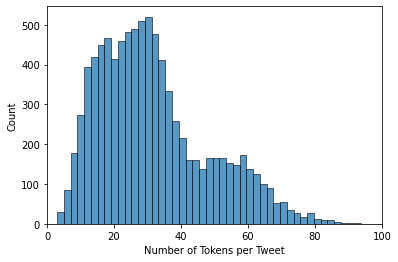

In [34]:
token_lens = []

for each_tweet in hate_train_df.tweet:
  
  tokens = tokenizer.encode(each_tweet, max_length=512) # max length by the model
  token_lens.append(len(tokens)) 


sns.histplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Number of Tokens per Tweet'); 

In [35]:
hate_train = pd.concat([hate_train_df, hate_train_labels], axis=1) 
hate_val = pd.concat([hate_val_df, hate_val_labels], axis=1) 
hate_test = pd.concat([hate_test_df, hate_test_labels], axis=1) 

for i in hate_train["tweet"][:20]:
    print(i)

@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you… 
A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎 
@user @user real talk do you have eyes or were they gouged out by a rapefugee? 
your girlfriend lookin at me like a groupie in this bitch! 
Hysterical woman like @user 
Me flirting- So tell me about your father... 
The Philippine Catholic bishops' work for migrant workers should focus on families who are "paying the great... 
I AM NOT GOING AFTER YOUR EX BF YOU LIEING SACK OF SHIT ! I'm done with you dude that's why I dumped your ass cause your a lieing 😂😡 bitch 
When cuffin season is finally over 
Send home migrants not in need of protection, Peter Dutton tells UN, HEY DUTTON HOW ABOUT THE ONES THAT HAVE STAYED AND NOT LEFT THE COUNTRY WHEN THEY SHOULD OVERSTAYERS ? WHY DONT YOU GO AND ROUND ALL THEM UP ?  
Cory Booker and Kamala Harris competing for Most Hysterical Woman at t

In [36]:
tokenizer = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = normTweet.replace("cannot ", "can not ").replace("n't ", " n't ").replace("n 't ", " n't ").replace("ca n't", "can't").replace("ai n't", "ain't")
    normTweet = normTweet.replace("'m ", " 'm ").replace("'re ", " 're ").replace("'s ", " 's ").replace("'ll ", " 'll ").replace("'d ", " 'd ").replace("'ve ", " 've ")
    normTweet = normTweet.replace(" p . m .", "  p.m.") .replace(" p . m ", " p.m ").replace(" a . m .", " a.m.").replace(" a . m ", " a.m ")

    normTweet = re.sub(r",([0-9]{2,4}) , ([0-9]{2,4})", r",\1,\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3}) / ([0-9]{2,4})", r"\1/\2", normTweet)
    normTweet = re.sub(r"([0-9]{1,3})- ([0-9]{2,4})", r"\1-\2", normTweet)
    normTweet = normTweet.replace('@USER', '')
    normTweet = normTweet.replace('HTTPURL', '')
    return " ".join(normTweet.split())

# Testing the pre-processing functions
print(normalizeTweet("SC has first two presumptive cases of coronavirus, DHEC confirms https://postandcourier.com/health/covid19/ … via @postandcourier"))
print(normalizeTweet("So. Many. Plot twists. 😩😭😭😭😭 #Westworld #WestworldFinale "))
print(normalizeTweet("@user @user @user Tamra would F her up if she swung on Tamra\nKelly is a piece of 💩 #needstobeadmitted #bully"))
print(normalizeTweet("in my dream....They were trying to steal my kidney!!!  #blackmarket #whydidiwatchthat "))

SC has first two presumptive cases of coronavirus , DHEC confirms ... via
So . Many . Plot twists . :weary_face: :loudly_crying_face: :loudly_crying_face: :loudly_crying_face: #Westworld #WestworldFinale
Tamra would F her up if she swung on Tamra Kelly is a piece of :pile_of_poo: #needstobeadmitted #bully
in my dream ... They were trying to steal my kidney ! ! ! #blackmarket #whydidiwatchthat


In [37]:
!pip install ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [38]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",
    #    'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

def preprocess_tweets(s):
    s = " ".join(text_processor.pre_process_doc(s))
    s = ' '.join(k for k, _ in itertools.groupby(s.split()))
    s = s.replace("' ", "'").replace(" '", "'")
    s = " ".join(s.split())
    s = s.strip()
    s = s.replace('“', "")
    # s = s.replace("<user>", '')
    # s = demojize(s)
    return s
    
# Test Sentences
sentences = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
    "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/.",
    "'You have a #problem? Yes! Can you do #something about it? No! Than why  '",
    "on the bright side , my music theory teacher just pocket dabbed and said ,'i know what's hip .'and walked away "
]

for i in sentences:
    print(preprocess_tweets(i))

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...
cant wait for the new season of twin peaks ＼(^o^)／ ! david lynch tv series <happy>
i saw the new john doe movie and it suuuuucks ! waisted <money> . bad movies <annoyed>
<user> : can not wait for the <date> sentiment talks ! yaaaaaay ! <laugh> <url>
'you have a problem ? yes ! can you do something about it ? no ! than why'
on the bright side , my music theory teacher just pocket dabbed and said ,'i know what's hip .'and walked away


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [39]:
hate_train['tweet'] = hate_train['tweet'].apply(lambda x: preprocess_tweets(x))
hate_val['tweet'] = hate_val['tweet'].apply(lambda x: preprocess_tweets(x))
hate_test['tweet'] = hate_test['tweet'].apply(lambda x: preprocess_tweets(x))

del hate_train_df, hate_train_labels, hate_val_df, hate_val_labels, hate_test_df, hate_test_labels

In [40]:
hate_train.head()

,tweet,label
0,<user> nice new signage . are you not concerne...,0
1,a woman who you fucked multiple times saying y...,1
2,<user> real talk do you have eyes or were they...,1
3,your girlfriend lookin at me like a groupie in...,1
4,hysterical woman like <user>,0


In [41]:
hate_train.label.value_counts()

0    5210
1    3783
Name: label, dtype: int64

In [42]:
# pre-processed/clean input
for i in hate_train["tweet"][:20]:
    print(i)

<user> nice new signage . are you not concerned by beatlemania - style hysterical crowds crongregating on you …
a woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎
<user> real talk do you have eyes or were they gouged out by a rapefugee ?
your girlfriend lookin at me like a groupie in this bitch !
hysterical woman like <user>
me flirting - so tell me about your father .
the philippine catholic bishops'work for migrant workers should focus on families who are " paying the great .
i am not going after your ex bf you lieing sack of shit ! i am done with you dude that's why i dumped your ass cause your a lieing 😂 😡 bitch
when cuffin season is finally over
send home migrants not in need of protection , peter dutton tells un , hey dutton how about the ones that have stayed and not left the country when they should overstayers ? why dont you go and round all them up ?
cory booker and kamala harris competing for most hysterical woman at the kav

## Fine-Tuning and Evaluating the Model

In [43]:
import wandb

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print(cuda_available)


train_args = {
              'manual_seed':41,
              'save_steps' : 2000,
              'save_model_every_epoch' : True,
              'save_eval_checkpoints' : True, # s false
              "warmup_steps": 100, # s 100
              'use_early_stopping' : True, # False
              'early_stopping_delta' : 0.01, # s 0.01
              'early_stopping_metric' : "eval_loss", # s mcc
              'early_stopping_metric_minimize' : True, #True
              'early_stopping_patience' : 5, # s 5
              'evaluate_during_training_steps' : 125, # 2000
              'no_cache' : True, # False
              'num_train_epochs':3, 
              'train_batch_size':32, # 8
              'eval_batch_size': 32,
              'max_seq_length':100, # 128
              'learning_rate':4e-5,
              'optimizer': "AdamW",
              'use_tensorboard': True,
              'evaluate_during_training': True,
              'overwrite_output_dir': True, 
              "use_multiprocessing": False, # False
              "use_multiprocessing_for_evaluation" : False,
              "use_multiprocessed_decoding" : False,
              'wandb_project': "CE888"}

trained_model = ClassificationModel(model_type = 'bertweet',
                                    model_name = 'vinai/bertweet-base',
                                    tokenizer_name = "vinai/bertweet-base",
                                    num_labels=2, 
                                    use_cuda=True, 
                                    #cuda_device=0, 
                                    args=train_args)

True


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classi

In [44]:
trained_model.train_model(hate_train, eval_df=hate_val)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.
wandb: Currently logged in as: ihab09 (use `wandb login --relogin` to force relogin)


Running Epoch 0 of 3:   0%|          | 0/282 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Datafr

Running Epoch 1 of 3:   0%|          | 0/282 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Epoch 2 of 3:   0%|          | 0/282 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 5
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Training of bertweet model complete. Saved to outputs/.


(846,
 {'auprc': [0.820639396134024,
   0.8331494989065655,
   0.8434081903492112,
   0.8384987796065393,
   0.8366875814570668,
   0.8537541672823579,
   0.8454970265323463,
   0.8286718885071028,
   0.8331750295662614],
  'auroc': [0.8653764268518367,
   0.8727235878875224,
   0.8815794860876827,
   0.874490263834526,
   0.8790574179918441,
   0.8915633546781088,
   0.8863349764989109,
   0.8873974386269468,
   0.8883002243657983],
  'eval_loss': [0.4732818063348532,
   0.4948878441937268,
   0.43507211469113827,
   0.5123050403781235,
   0.4709118381142616,
   0.42487345077097416,
   0.5174154839478433,
   0.5639110589399934,
   0.5429381616413593],
  'fn': [81, 39, 65, 129, 99, 71, 72, 68, 83],
  'fp': [131, 197, 137, 76, 108, 122, 117, 126, 118],
  'global_step': [125, 250, 282, 375, 500, 564, 625, 750, 846],
  'mcc': [0.5757122685028475,
   0.5666471860921104,
   0.6018236917017339,
   0.5775690499890468,
   0.577892483693813,
   0.6144361924729157,
   0.6211403873171555,
   0.61

In [45]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

from sklearn.metrics import recall_score

def macro_recall(labels, preds):
    return recall_score(labels, preds, average='macro')

result, model_outputs, wrong_predictions = trained_model.eval_model(hate_test, mavg_f1=f1_multiclass, acc=accuracy_score, mavg_recall = macro_recall)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Running Evaluation:   0%|          | 0/93 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


Training loss,0.12156
lr,0.0
global_step,846
_runtime,417
_timestamp,1619433356
_step,24
tp,344
tn,454
fp,118
fn,83
mcc,0.59466


Training loss,█▅▅▅▆▅▆▂▃▁▅▂▃▁▁▁
lr,▄██▇▇▆▆▅▄▄▄▃▂▂▁▁
global_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
tp,▅█▆▁▃▆▅▆▅
tn,▅▁▄█▆▅▆▅▆
fp,▄█▅▁▃▄▃▄▃
fn,▄▁▃█▆▃▄▃▄
mcc,▂▁▆▂▂▇█▇▅


INFO:simpletransformers.classification.classification_model:{'mcc': 0.3405739024325329, 'tp': 1209, 'tn': 525, 'fp': 1193, 'fn': 43, 'auroc': 0.709592707546854, 'auprc': 0.6056668352727765, 'eval_loss': 1.503891864771484, 'mavg_f1': 0.5605290717970599, 'acc': 0.5838383838383838, 'mavg_recall': 0.6356214224876984}


Graphs showing the training process as imported from the Weights and Biases platform (wandb.ai).

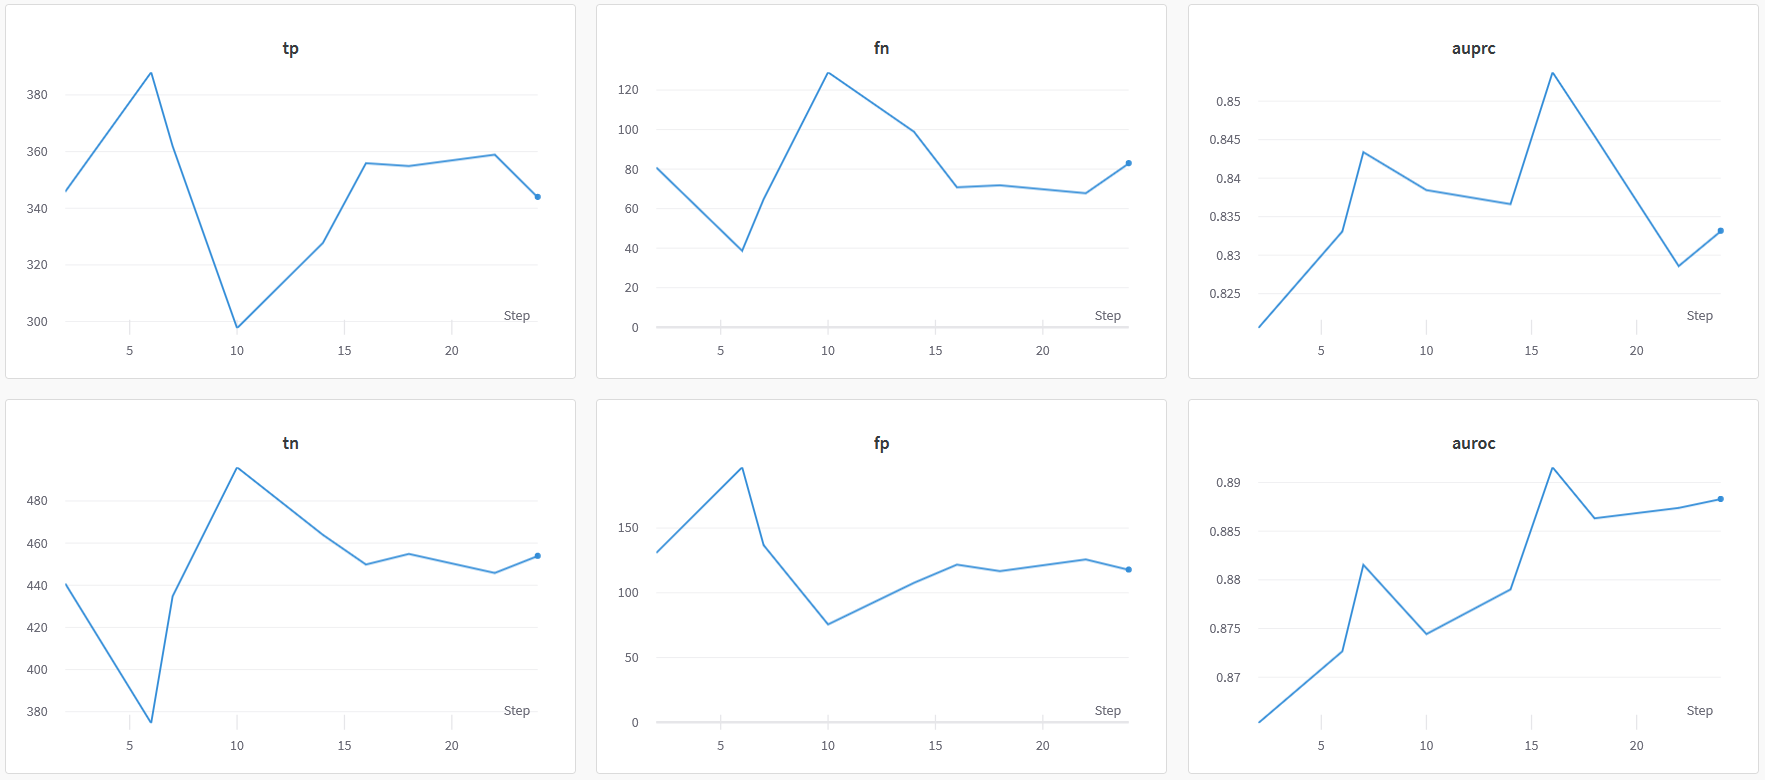

The confustion matrix showing that the second class "hateful" is correctly classified most of the time, while the first class "not hateful" is widely missclassified. 

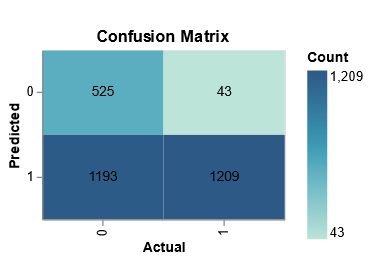

In [46]:
result

{'acc': 0.5838383838383838,
 'auprc': 0.6056668352727765,
 'auroc': 0.709592707546854,
 'eval_loss': 1.503891864771484,
 'fn': 43,
 'fp': 1193,
 'mavg_f1': 0.5605290717970599,
 'mavg_recall': 0.6356214224876984,
 'mcc': 0.3405739024325329,
 'tn': 525,
 'tp': 1209}

### Macro-Averaged F1 Score

In [47]:
print("Macro-Averaged F1 Score: ", result['mavg_f1']*100)

Macro-Averaged F1 Score:  56.05290717970599


In [48]:
# Plays an audio message as a notification when the training process is done.
import IPython.display as display
display.Audio(url="https://static.sfdict.com/audio/C07/C0702600.mp3", autoplay=True)

## Saving the best model

In [ ]:
# Transforming the model folder into a single compressed file.
!zip -r /content/outputs/best_model_file.zip /content/outputs/best_model

In [ ]:
# Downloading the model locally.
from google.colab import files
files.download("/content/outputs/best_model_file.zip")

## Loading the saved model

In [ ]:
# If you don't want to retrain the model, you can load the best saved model directly by running the code below.
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print(cuda_available)

import wandb

trained_model = ClassificationModel(
    "deperta", "outputs/best_model"
    # "bertweet", "outputs/checkpoint-612-epoch-6"
)